In [1]:
import numpy as np
from numba import njit
from scipy import sparse, linalg
from scipy.io import mmread, mmwrite
from adaptive_step_dmm import CAdaptiveDMM
from adaptive_step_DMM_sqrt import CAdaptiveDMMsqrt
from adaptive_GC import CAdaptive_GC_RK4
from adaptive_GC_sqrt import CAdaptive_GC_RK4_sqrt
import matplotlib.pyplot as plt
import time

In [2]:
# Set font size of plot elements
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
def get_exact(H, S, num_electrons, beta, mu):
    inv_S = linalg.inv(S)
    return S @ linalg.funm(inv_S @ H,
                lambda _: np.exp(-beta * (_ - mu)) / (1 + np.exp(-beta * (_ - mu))))

In [4]:
def plot_results_fd_vs_gc(num_electrons, fd, gc):
    H = gc.H
    S = gc.ovlp
    
    # Plot final eigenvalue spectra of the exact solution and our methods results
    fignum = 1
    plt.figure(fignum)
    #plt.title("Populations - " + str(num_electrons) + " electrons")
    plt.plot(linalg.eigvalsh(H, S), linalg.eigvalsh(fd, S)[::-1], 'ks-', label="Exact by FD")
    plt.plot(linalg.eigvalsh(H, S), linalg.eigvalsh(gc.rho, S)[::-1], 'r^-', 
             label="Grand Can. WOM")
    #plt.xlabel("Energy")
    plt.ylabel("Population")
    plt.legend(numpoints=1)
    plt.savefig("larger_matrices/sqrt_figs/GC/" + str(num_electrons) + "/rk2_GC_pop.png", format='png', dpi=300)
    print(gc.beta)
    
    # Plot increments of dbeta that our method took
    fignum += 1
    plt.figure(fignum)
    plt.title("Variable step method in action - " + str(num_electrons) + "electrons")
    plt.plot(gc.beta_increments, '*-')
    plt.xlabel('steps')
    plt.ylabel('dbeta')
    plt.savefig("larger_matrices/sqrt_figs/GC/" + str(num_electrons) + "/GC_dbeta_inc.png", format='png', dpi=300)
    
    # Plot number of electrons
    fignum += 1
    plt.figure(fignum)
    plt.title("Change in number of electrons - " + str(num_electrons) + " electrons")
    plt.plot(gc.num_electron_list, '*-')
    plt.xlabel("steps")
    plt.ylabel("num_electrons")
    plt.savefig("larger_matrices/sqrt_figs/GC/" + str(num_electrons) + "/GC_num_electrons.png", format='png', dpi=300)
    
    # Plot chemical potential
    fignum += 1
    plt.figure(fignum)
    plt.title("Change in chemical potential - " + str(num_electrons) + " electrons")
    plt.plot(gc.mu_list, '*-')
    plt.xlabel("steps")
    plt.ylabel("mu")
    plt.savefig("larger_matrices/sqrt_figs/GC/" + str(num_electrons) + "/GC_chem_pot.png", format='png', dpi=300)

    # Check beta vs step size
    beta_vals = np.cumsum(gc.beta_increments)
    fignum += 1
    plt.figure(fignum)
    plt.plot(gc.beta_increments, beta_vals)
    plt.xlabel("dbeta")
    plt.ylabel("beta")
    plt.title("beta vs step size - " + str(num_electrons) + " electrons")
    plt.savefig("larger_matrices/sqrt_figs/GC/" + str(num_electrons) + "/GC_beta_vs_stepsize.png", format='png', dpi=300)
    
    # Plot energy values
    fignum += 1
    plt.figure(fignum)
    plt.title("Energy values vs temp - " + str(num_electrons) + " electrons")
    plt.plot(beta_vals, (gc.energy_vals - min(gc.energy_vals))[:-1])
    plt.xlabel("beta")
    plt.ylabel("E(beta) - min(E)")
    plt.savefig("larger_matrices/sqrt_figs/GC/" + str(num_electrons) + "/GC_energy_vs_beta.png", format='png', dpi=300)
    
    # Plot energy values
    fignum += 1
    plt.figure(fignum)
    plt.title("Energy values vs steps - " + str(num_electrons) + " electrons")
    plt.semilogy((gc.energy_vals - min(gc.energy_vals))[:-1])
    plt.xlabel("steps")
    plt.ylabel("E(step) - E.min")
    plt.savefig("larger_matrices/sqrt_figs/GC/" + str(num_electrons) + "/GC_energy_vs_steps.png", format='png', dpi=300)

In [5]:
# Define path for matrices
matrices_path = "larger_matrices/"

### 32 electrons

In [6]:
# Define path to H and S matrices
H_16 = mmread(matrices_path + "16_H.mtx").toarray()
S_16 = mmread(matrices_path + "16_S.mtx").toarray()

# We need the eigenvalues and eigenvectors for H
E, V = linalg.eigh(H_16, S_16)

# Define num_electrons and beta
num_electrons = 32
beta = 100
dbeta = 0.13

# Define chemical potential
core_spec = linalg.eigvalsh(H_16, S_16)
index = int(num_electrons / 2)
mu = (core_spec[index] + core_spec[index - 1]) / 2

In [7]:
np.allclose(H_16 @ V[:, 1], E[1] * S_16 @ V[:, 1])

True

In [8]:
sqrt_gc_16 = CAdaptive_GC_RK4_sqrt(ovlp=S_16, H=H_16, 
                                   dbeta=dbeta, epsilon=1e-2, mu=mu)
sqrt_gc_16.propagate(beta)
ferm_exact_16 = get_exact(H_16, S_16, num_electrons, sqrt_gc_16.beta, sqrt_gc_16.mu)

Energy_next > energy
funm result may be inaccurate, approximate err = 1


7.813067977552853


/home/jacob/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/jacob/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/jacob/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


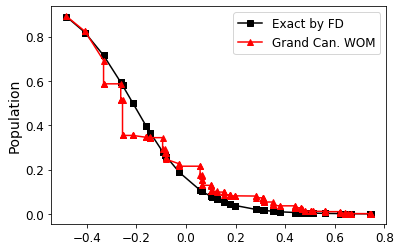

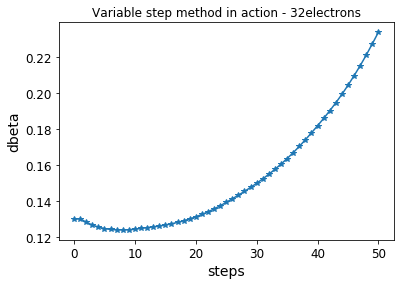

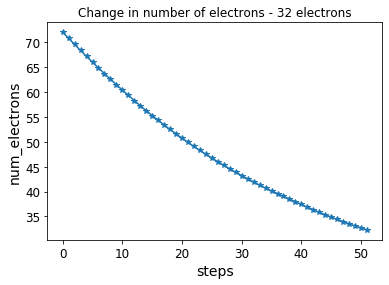

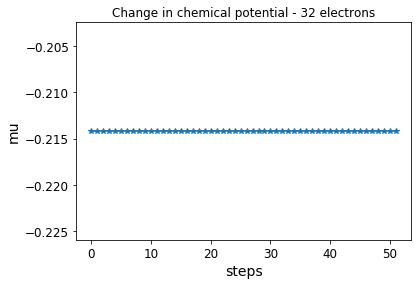

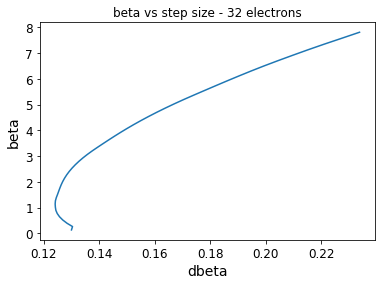

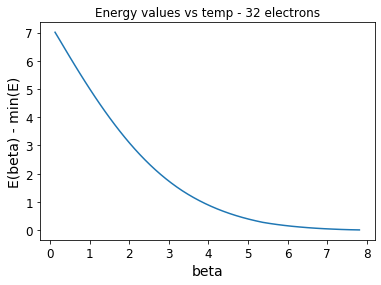

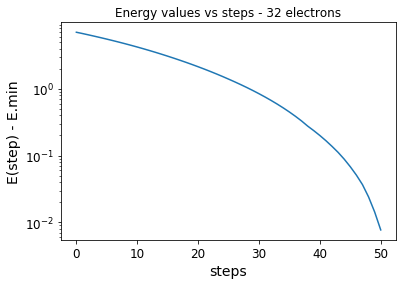

In [9]:
plot_results_fd_vs_gc(num_electrons, ferm_exact_16, sqrt_gc_16)

In [10]:
# We want to confirm that our method is able to go forwards and backwards
test_gc = CAdaptive_GC_RK4_sqrt(ovlp=S_16, H=H_16, rho=sqrt_gc_16.rho, 
                                omega=sqrt_gc_16.omega,
                               dbeta=-dbeta, epsilon=1e-2, mu=mu, beta=sqrt_gc_16.beta)
beta_final = sqrt_gc_16.beta - 10
test_gc.back_propagate(beta_final)

array([[ 6.38507174e-01+0.j,  4.22458522e-17+0.j, -2.09854748e-16+0.j,
        ...,  1.32098338e-02+0.j,  3.49414177e-02+0.j,
        -1.47962226e-16+0.j],
       [ 2.62099013e-17+0.j,  7.20610267e-01+0.j,  9.81654297e-17+0.j,
        ...,  2.93064220e-02+0.j,  3.87888670e-02+0.j,
         2.12877806e-02+0.j],
       [-2.55870226e-16+0.j,  1.23473066e-18+0.j,  7.21632199e-01+0.j,
        ..., -7.79521300e-03+0.j,  3.83179451e-02+0.j,
        -1.80593193e-16+0.j],
       ...,
       [ 1.32098338e-02+0.j,  2.93064220e-02+0.j, -7.79521300e-03+0.j,
        ...,  7.22123694e-01+0.j, -4.86590752e-17+0.j,
         1.25663018e-16+0.j],
       [ 3.49414177e-02+0.j,  3.87888670e-02+0.j,  3.83179451e-02+0.j,
        ..., -1.25163346e-16+0.j,  7.66126202e-01+0.j,
         2.12827886e-16+0.j],
       [-5.35412322e-17+0.j,  2.12877806e-02+0.j, -1.20963906e-16+0.j,
        ...,  6.73836638e-17+0.j,  1.55221273e-16+0.j,
         7.39296838e-01+0.j]])

In [11]:
test_gc.dbeta = -test_gc.dbeta
test_gc.previous_dbeta = 0
beta = 100
test_gc.propagate(beta)
test_gc.beta

Energy_next > energy


7.997131518723491

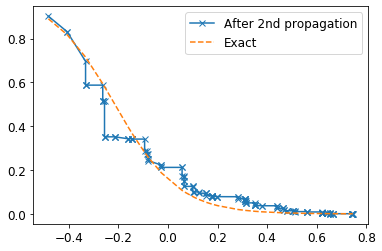

In [12]:
plt.plot(E, linalg.eigvalsh(test_gc.rho, S_16)[::-1],
         'x-', label='After 2nd propagation')
plt.plot(E, linalg.eigvalsh(ferm_exact_16, S_16)[::-1], '--', label='Exact')
plt.legend(numpoints=1)

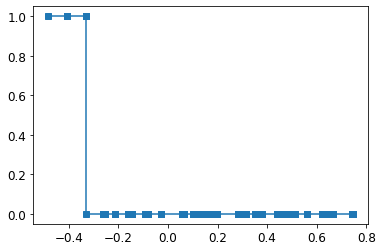

In [13]:
# Now we want to check what happens when we start at the ground state and 
# increase the temperature a bit
inv_V = linalg.inv(V)
diag_H = np.diag(E)
inv_S_16 = linalg.inv(S_16)
beta = 150
x = V @ diag_H @ inv_V
#test_P = S_16 @ V @ linalg.funm(diag_H,
#                lambda _: 1 / (1 + np.exp(beta * (_ - mu)))) @ inv_V
test_P = S_16 @ V @ np.diag(E < E[6])  @ inv_V
plt.plot(E, linalg.eigvalsh(test_P, S_16)[::-1], 's-')

In [14]:
np.trace(test_P)

14.846667280504708

In [15]:
# Now create a case starting at the point beta=150
gs_gc_16 = CAdaptive_GC_RK4_sqrt(ovlp=S_16, H=H_16, rho=test_P, 
                                omega=linalg.sqrtm(test_P),
                               dbeta=-dbeta, epsilon=1e-2, mu=mu, beta=beta)
gs_gc_16.back_propagate(beta - 25)

ZeroDivisionError: float division by zero

In [ ]:
plt.plot(E, linalg.eigvalsh(gs_gc_16.rho, S_16)[::-1])
plt.title("From $\\beta=150$ to $\\beta=125$")

In [ ]:
gs_gc_16.dbeta *= -1
gs_gc_16.previous_dbeta = 0
gs_gc_16.propagate(beta)

In [ ]:
plt.plot(E, linalg.eigvalsh(ferm_exact_16, S_16)[::-1], 's-', label='Exact')
plt.plot(E, linalg.eigvalsh(gs_gc_16.rho, S_16)[::-1], 'x-', label='Reiterating')
plt.title("From $\\beta=125$ to $\\beta=150$")
plt.legend(numpoints=1)

### 108 electrons

In [ ]:
# Define path to H and S matrices
H_54 = mmread(matrices_path + "54_H.mtx").toarray()
S_54 = mmread(matrices_path + "54_S.mtx").toarray()

# Define num_electrons and beta
num_electrons = 108
beta = 100
dbeta = 0.13

# Define chemical potential
core_spec = linalg.eigvalsh(H_54, S_54)
index = int(num_electrons / 2)
mu = (core_spec[index] + core_spec[index - 1]) / 2

In [ ]:
sqrt_gc_54 = CAdaptive_GC_RK4_sqrt(ovlp=S_54, H=H_54,
                                   dbeta=dbeta, epsilon=1e-2, mu=mu)
sqrt_gc_54.propagate(beta)
ferm_exact_54 = get_exact(H_54, S_54, num_electrons, sqrt_gc_54.beta, sqrt_gc_54.mu)

In [ ]:
plot_results_fd_vs_gc(num_electrons, ferm_exact_54, sqrt_gc_54)

In [ ]:
print(sqrt_gc_16.beta_increments[0])
print(sqrt_gc_54.beta_increments[0])

### 256 electrons

In [ ]:
# Define path to H and S matrices
H_128 = mmread(matrices_path + "128_H.mtx").toarray()
S_128 = mmread(matrices_path + "128_S.mtx").toarray()

# Define num_electrons and beta
num_electrons = 256
beta = 100
dbeta = beta / 10000

# Define chemical potential
core_spec = linalg.eigvalsh(H_128, S_128)
index = int(num_electrons / 2)
mu = (core_spec[index] + core_spec[index - 1]) / 2

In [ ]:
sqrt_gc_128 = CAdaptive_GC_RK4_sqrt(ovlp=S_128, H=H_128,
                                    dbeta=dbeta, epsilon=1e-2, mu=mu)
sqrt_gc_128.propagate(beta)
ferm_exact_128 = get_exact(H_128, S_128, num_electrons, sqrt_gc_128.beta, sqrt_gc_128.mu)

In [ ]:
plot_results_fd_vs_gc(num_electrons, ferm_exact_128, sqrt_gc_128)

### 500 electrons

In [ ]:
# Define path to H and S matrices
H_250 = mmread(matrices_path + "250_H.mtx").toarray()
S_250 = mmread(matrices_path + "250_S.mtx").toarray()

# Define num_electrons and beta
num_electrons = 500
beta = 100
dbeta = beta / 10000

# Define chemical potential
core_spec = linalg.eigvalsh(H_250, S_250)
index = int(num_electrons / 2)
mu = (core_spec[index] + core_spec[index - 1]) / 2

In [ ]:
sqrt_gc_250 = CAdaptive_GC_RK4_sqrt(ovlp=S_250, H=H_250,
                                    dbeta=dbeta, epsilon=1e-2, mu=mu)
sqrt_gc_250.propagate(beta)
ferm_exact_250 = get_exact(H_250, S_250, num_electrons, sqrt_gc_250.beta, sqrt_gc_250.mu)

In [ ]:
plot_results_fd_vs_gc(num_electrons, ferm_exact_250, sqrt_gc_250)

### Comparison

In [ ]:
x = [1, 2, 3, 4]
y = [len(sqrt_gc_16.energy_vals), len(sqrt_gc_54.energy_vals), len(sqrt_gc_128.energy_vals), \
     len(sqrt_gc_250.energy_vals)]
ax = plt.subplot()
ax.bar(x, y, color='maroon')
ax.set_ylabel("Number of Steps")
ax.set_xticklabels(['16', '54', '128', '250'])
ax.set_xticks(x)
#ax.set_xlabel("Num atoms")
#plt.title("GC Steps vs Num Atoms")
plt.savefig("larger_matrices/sqrt_figs/GC/gc_steps_vs_size.png", format='png', dpi=300)